# Import Library

In [46]:
import mnist

In [47]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# GAN Architecture

## Generator 👨🏻‍🎨

In [48]:
def GenBlock(in_dim:int,out_dim:int):
   
    return nn.Sequential(
        nn.Linear(in_dim,out_dim),
        nn.BatchNorm(out_dim),
        nn.ReLU()
    )

In [49]:
class Generator(nn.Module):

    def __init__(self, z_dim:int = 10, im_dim:int = 784, hidden_dim: int =128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            GenBlock(z_dim, hidden_dim),
            GenBlock(hidden_dim, hidden_dim * 2),
            GenBlock(hidden_dim * 2, hidden_dim * 4),
            GenBlock(hidden_dim * 4, hidden_dim * 8),


            nn.Linear(hidden_dim * 8,im_dim),
            nn.Sigmoid()
        )
        
    def __call__(self, noise):

        return self.gen(noise)

In [50]:
gen = Generator(100)
gen

Generator(
  (gen): Sequential(
    (layers.0): Sequential(
      (layers.0): Linear(input_dims=100, output_dims=128, bias=True)
      (layers.1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): ReLU()
    )
    (layers.1): Sequential(
      (layers.0): Linear(input_dims=128, output_dims=256, bias=True)
      (layers.1): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): ReLU()
    )
    (layers.2): Sequential(
      (layers.0): Linear(input_dims=256, output_dims=512, bias=True)
      (layers.1): BatchNorm(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): ReLU()
    )
    (layers.3): Sequential(
      (layers.0): Linear(input_dims=512, output_dims=1024, bias=True)
      (layers.1): BatchNorm(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): ReLU()
    )
    (layers.4): Linear(input_dims=1024, output_dims=784, bias=True

In [51]:
def get_noise(n_samples, z_dim):
    return np.random.randn(n_samples,z_dim)

## Discriminator 🕵🏻‍♂️

In [52]:
def DisBlock(in_dim:int,out_dim:int):
    return nn.Sequential(
        nn.Linear(in_dim,out_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )

In [53]:
class Discriminator(nn.Module):

    def __init__(self,im_dim:int = 784, hidden_dim:int = 128):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            DisBlock(im_dim, hidden_dim * 4),
            DisBlock(hidden_dim * 4, hidden_dim * 2),
            DisBlock(hidden_dim * 2, hidden_dim),

            nn.Linear(hidden_dim,1),
        )
        
    def __call__(self, noise):

        return self.disc(noise)

In [54]:
disc = Discriminator()
disc

Discriminator(
  (disc): Sequential(
    (layers.0): Sequential(
      (layers.0): Linear(input_dims=784, output_dims=512, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.1): Sequential(
      (layers.0): Linear(input_dims=512, output_dims=256, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.2): Sequential(
      (layers.0): Linear(input_dims=256, output_dims=128, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.3): Linear(input_dims=128, output_dims=1, bias=True)
  )
)

# Model Training 🏋🏻‍♂️

In [55]:
# Set your parameters
criterion = nn.losses.binary_cross_entropy
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

In [56]:
gen = Generator(z_dim)
mx.eval(gen.parameters())
gen_opt = optim.Adam(learning_rate=lr)

disc = Discriminator()
mx.eval(disc.parameters())
disc_opt = optim.Adam(learning_rate=lr)

## Losses

In [57]:
def disc_loss(gen, disc, real, num_images, z_dim):
    noise =  mx.array(get_noise(num_images, z_dim))
    fake_images = gen(noise)
        
    fake_disc = disc(fake_images)
    
    fake_labels = mx.zeros((fake_images.shape[0],1))
    fake_loss = nn.losses.binary_cross_entropy(fake_disc,fake_labels,with_logits=True)
    
    real_disc = disc(real)
    real_labels = mx.ones((real.shape[0],1))

    real_loss = nn.losses.binary_cross_entropy(real_disc,real_labels,with_logits=True)

    disc_loss = (fake_loss + real_loss) / 2

    return disc_loss

In [58]:
def gen_loss(gen, disc, num_images, z_dim):

    noise = mx.array(get_noise(num_images, z_dim))
    fake_images = gen(noise)
    fake_disc = disc(fake_images)

    fake_labels = mx.ones((fake_images.shape[0],1))
    
    gen_loss = nn.losses.binary_cross_entropy(fake_disc,fake_labels,with_logits=True)

    return gen_loss

In [59]:
train_images, _, test_images, _ = map(
    mx.array, getattr(mnist, 'mnist')()
)

In [133]:
len(train_images)

60000

In [60]:
def batch_iterate(batch_size: int, ipt: list):
    perm = np.random.permutation(len(ipt))
    for s in range(0, len(ipt), batch_size):
        ids = perm[s : s + batch_size]
        yield [ipt[i] for i in ids]

### show batch of images

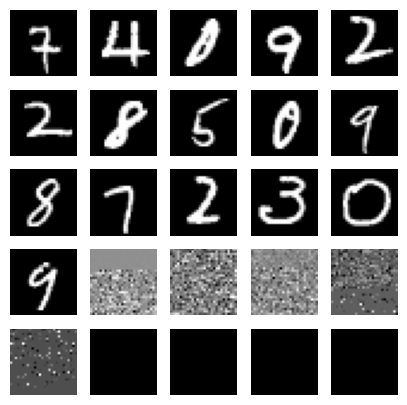

In [128]:
for X in batch_iterate(16, train_images):
    fig,axes = plt.subplots(5, 5, figsize=(5, 5))

    for i, ax in enumerate(axes.flat):
        img = mx.array(X[i]).reshape(28,28)
        ax.imshow(img,cmap='gray')
        ax.axis('off')
    break

In [147]:
def show_images(imgs:list[int],num_imgs:int = 25):
    if (imgs.shape[0] > 0): 
        fig,axes = plt.subplots(5, 5, figsize=(5, 5))
        
        for i, ax in enumerate(axes.flat):
            img = mx.array(imgs[0]).reshape(28,28)
            ax.imshow(img,cmap='gray')
            ax.axis('off')
        plt.show()

In [148]:
z_dim = 64
gen = Generator(z_dim)
mx.eval(gen.parameters())
gen_opt = optim.Adam(learning_rate=lr)

disc = Discriminator()
mx.eval(disc.parameters())
disc_opt = optim.Adam(learning_rate=lr)


In [162]:
train_images, train_labels, test_images, test_labels = map(mx.array, mnist.mnist())
print(min(train_images[0]))
# train_images = train_images * 2.0 - 1.0 # normalize the image

array(0, dtype=float32)


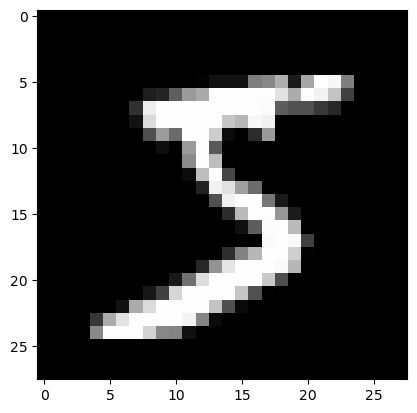

In [156]:
plt.imshow(train_images[0].reshape(28,28),cmap='gray')

In [151]:
# Train the GAN for only 1000 images
batch_size = 128
display_step = 15
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

D_loss_grad = nn.value_and_grad(disc, disc_loss)
G_loss_grad = nn.value_and_grad(gen, gen_loss)


for epoch in tqdm(range(60)):

    for real in batch_iterate(batch_size, train_images[:2048]):
                
        D_loss,D_grads = D_loss_grad(gen, disc, real, cur_batch_size, z_dim)

        # Update optimizer
        disc_opt.update(disc, D_grads)
        
        # Update gradients
        mx.eval(disc.parameters(), disc_opt.state)

        G_loss,G_grads = G_loss_grad(gen, disc, cur_batch_size, z_dim)
        
        # Update optimizer
        gen_opt.update(gen, G_grads)
        
        # Update gradients
        mx.eval(gen.parameters(), gen_opt.state)
        
        
    if cur_step % display_step == 0 and cur_step > 0 and batch_size:
        print(f"Step {epoch}: Generator loss: {G_loss}, discriminator loss: {D_loss}")
        fake_noise = mx.array(get_noise(batch_size, z_dim))
        fake = gen(fake_noise)
        show_images(fake)
        show_images(real)
    cur_step += 1

  7%|▋         | 4/60 [08:34<2:00:03, 128.64s/it]


KeyboardInterrupt: 